In [118]:
from src.model_fusion.model import UNET
from src.model_fusion.dataset import RSDataset
from src.model_planet.dataset import PlanetDataset
from torch.utils.data import DataLoader
from skimage.exposure import rescale_intensity, adjust_gamma
import cv2
import matplotlib.pyplot as plt
import rasterio
import glob
import numpy as np
import torch

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 16
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
IMG_DIR = '../data/ai_data/val_images/'
MASK_DIR = '../data/ai_data/val_masks/'

In [11]:
ds = RSDataset(
    image_dir=IMG_DIR,
    mask_dir=MASK_DIR,
    transform=False)


loader = DataLoader(
    ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False)

In [161]:
def normalize_image(image):
    # Convert the image to floating-point values
    image = image.astype(np.float32)
    # Normalize the image to the range [0, 1]
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    return image

images = []
gd_truth = []
files_planet = sorted(glob.glob(IMG_DIR + '*planet.tif'))
files_ref = sorted(glob.glob(MASK_DIR + '*ref.tif'))

for tile_number in range(len(files_planet)):
    with rasterio.open(files_planet[tile_number]) as planet_ds:
        planet = normalize_image(np.transpose(planet_ds.read()[0:3], (1, 2, 0)))
        planet = adjust_gamma(planet, 0.8)
        images.append(planet)

for tile_number in range(len(files_ref)):
    with rasterio.open(files_ref[tile_number]) as ref_ds:
        ref = ref_ds.read(1).astype(np.uint8)
        gd_truth.append(ref)


150

In [20]:
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
checkpoint = checkpoint = torch.load('../src/model_fusion/my_checkpoint.pth.tar')
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [136]:
predictions = []
model.eval()
with torch.no_grad():
    for x, y, z, m in loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        z = z.to(DEVICE)
        m = m.to(DEVICE).unsqueeze(1)
        preds = torch.sigmoid(model(x, y, z))
        preds = (preds > 0.5).float()
        numpy_array = preds.squeeze(dim=1).to('cpu').numpy()
        predictions.append(numpy_array)

all_predictions = np.concatenate(predictions, axis=0)

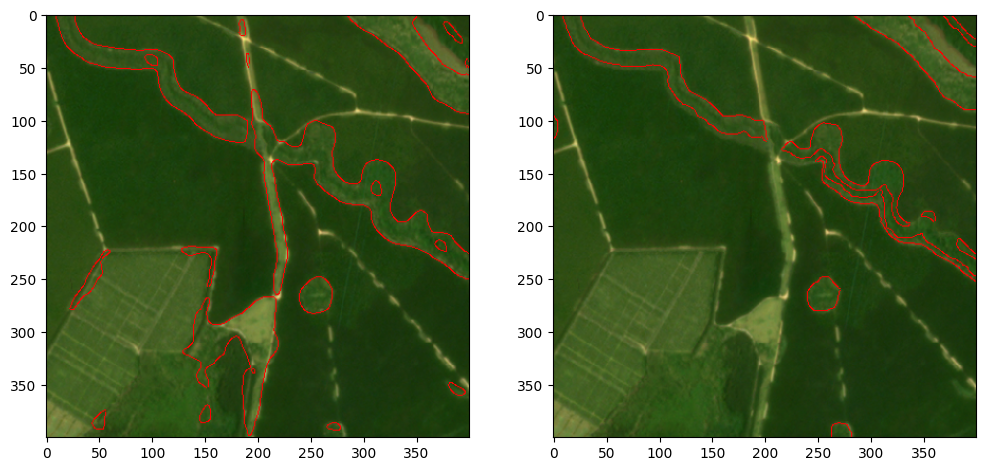

In [190]:
for idx in range(len(images)):
    image_planet = images[idx]
    prediction = all_predictions[idx].astype(np.uint8)
    reference = gd_truth[idx]
    
    edges = cv2.Canny(prediction, threshold1=0, threshold2=1)
    red_mask = np.stack((edges,) * 3, axis=-1)
    image = np.where(red_mask > 0, (1, 0, 0), image_planet)
    
    edges_ref = cv2.Canny(reference, threshold1=0, threshold2=1)
    red_mask_ref = np.stack((edges_ref,) * 3, axis=-1)
    image_2 = np.where(red_mask_ref > 0, (1, 0, 0), image_planet)

    if idx == 135:
        fig, axs = plt.subplots(1, 2, figsize=(12, 12))
        axs[0].imshow(image)
        axs[1].imshow(image_2)
        

##135 é top

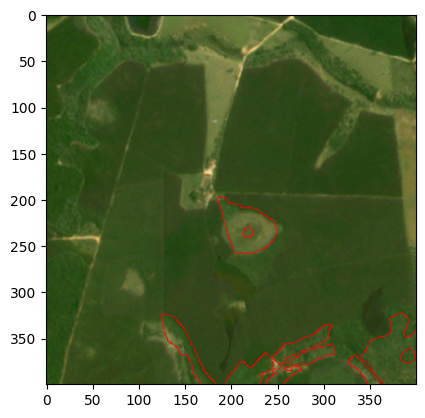

In [164]:
for idx in range(len(images)):
    image = images[idx]
    prediction = gd_truth[idx]
    
    edges = cv2.Canny(prediction, threshold1=0, threshold2=1)
    red_mask = np.stack((edges,) * 3, axis=-1)
    image = np.where(red_mask > 0, (1, 0, 0), image)

    if idx == 33:
        plt.imshow(image)

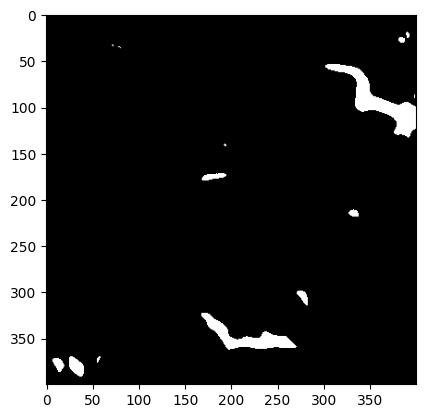